## Imports and Data Preprocessing

Import data and do basics of removing extraneous data

In [1]:
# Initial imports
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from keras.utils import np_utils

%matplotlib inline

In [2]:
# Import Verlander dataset 

verlander_df = pd.read_csv(Path("../resources/verlander_update.csv"),
                            index_col='game_date',
                            parse_dates=True,
                            infer_datetime_format=True)

display(verlander_df.head())

,pitch_type,player_name,batter,pitcher,events,description,zone,des,stand,p_throws,...,on_1b,outs_when_up,inning,at_bat_number,pitch_number,pitch_name,bat_score,fld_score,if_fielding_alignment,of_fielding_alignment
game_date,,,,,,,,,,,,,,,,,,,,,
2022-09-16,SL,"Verlander, Justin",669127,434378,strikeout,swinging_strike,9,Shea Langeliers strikes out swinging.,R,R,...,NaN,2,5,35,5,Slider,0,2,Infield shift,Standard
2022-09-16,FF,"Verlander, Justin",669127,434378,NaN,foul,3,Shea Langeliers strikes out swinging.,R,R,...,NaN,2,5,35,4,4-Seam Fastball,0,2,Infield shift,Standard
2022-09-16,SL,"Verlander, Justin",669127,434378,NaN,called_strike,13,Shea Langeliers strikes out swinging.,R,R,...,NaN,2,5,35,3,Slider,0,2,Infield shift,Standard
2022-09-16,FF,"Verlander, Justin",669127,434378,NaN,foul,1,Shea Langeliers strikes out swinging.,R,R,...,NaN,2,5,35,2,4-Seam Fastball,0,2,Infield shift,Standard
2022-09-16,SL,"Verlander, Justin",669127,434378,NaN,ball,8,Shea Langeliers strikes out swinging.,R,R,...,NaN,2,5,35,1,Slider,0,2,Infield shift,Standard


In [3]:
# Clean dataset 

verlander_df = verlander_df.drop(columns=['des', 
'pitch_name', 
'at_bat_number', 
'inning', 
'zone', 
'type', 
'player_name', 
'batter', 
'pitcher', 
'events',
'bb_type',
'hit_location',
'description',
'home_team',
'away_team'])

display(verlander_df.head())

,pitch_type,stand,p_throws,balls,strikes,on_3b,on_2b,on_1b,outs_when_up,pitch_number,bat_score,fld_score,if_fielding_alignment,of_fielding_alignment
game_date,,,,,,,,,,,,,,
2022-09-16,SL,R,R,1,2,NaN,NaN,NaN,2,5,0,2,Infield shift,Standard
2022-09-16,FF,R,R,1,2,NaN,NaN,NaN,2,4,0,2,Infield shift,Standard
2022-09-16,SL,R,R,1,1,NaN,NaN,NaN,2,3,0,2,Infield shift,Standard
2022-09-16,FF,R,R,1,0,NaN,NaN,NaN,2,2,0,2,Infield shift,Standard
2022-09-16,SL,R,R,0,0,NaN,NaN,NaN,2,1,0,2,Infield shift,Standard


In [4]:
# Encode 1st, 2nd and 3rd bases with 1s and 0s

# Fill NaN to 0 
verlander_df['on_3b'] = verlander_df['on_3b'].fillna(0)
verlander_df['on_2b'] = verlander_df['on_2b'].fillna(0)
verlander_df['on_1b'] = verlander_df['on_1b'].fillna(0)

# Change batter IDs to 1 
verlander_df['on_3b'][verlander_df['on_3b'] > 0.0] = 1.0
verlander_df['on_2b'][verlander_df['on_2b'] > 0.0] = 1.0
verlander_df['on_1b'][verlander_df['on_1b'] > 0.0] = 1.0

display(verlander_df[1000:1050])

/var/folders/zx/3xfmqcd54f3fdz2hfpnll0_80000gn/T/ipykernel_3599/1265769177.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  verlander_df['on_3b'][verlander_df['on_3b'] > 0.0] = 1.0
/var/folders/zx/3xfmqcd54f3fdz2hfpnll0_80000gn/T/ipykernel_3599/1265769177.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  verlander_df['on_2b'][verlander_df['on_2b'] > 0.0] = 1.0
/var/folders/zx/3xfmqcd54f3fdz2hfpnll0_80000gn/T/ipykernel_3599/1265769177.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

,pitch_type,stand,p_throws,balls,strikes,on_3b,on_2b,on_1b,outs_when_up,pitch_number,bat_score,fld_score,if_fielding_alignment,of_fielding_alignment
game_date,,,,,,,,,,,,,,
2022-06-29,FF,L,R,0,1,0.0,0.0,0.0,0,2,0,0,Standard,Standard
2022-06-29,FF,L,R,0,0,0.0,0.0,0.0,0,1,0,0,Standard,Standard
2022-06-29,CH,L,R,3,2,1.0,0.0,1.0,2,9,0,0,Standard,Standard
2022-06-29,FF,L,R,3,2,1.0,0.0,1.0,2,8,0,0,Standard,Standard
2022-06-29,SL,L,R,3,2,1.0,0.0,1.0,2,7,0,0,Standard,Standard
2022-06-29,FF,L,R,2,2,1.0,0.0,1.0,2,6,0,0,Standard,Standard
2022-06-29,FF,L,R,2,2,1.0,0.0,1.0,2,5,0,0,Standard,Standard
2022-06-29,FF,L,R,2,1,1.0,0.0,1.0,2,4,0,0,Standard,Standard
2022-06-29,FF,L,R,2,0,1.0,0.0,1.0,2,3,0,0,Standard,Standard


## Data Processing 

Prepare data to be fed into model

In [5]:
# Split into X and y 

X = verlander_df.drop(columns='pitch_type')
y= verlander_df['pitch_type']

In [6]:
# Use get_dummies to encode categorical variables 

X = pd.get_dummies(X)

#y = y.map({'CH': 1, 'CU': 2, 'FF': 3, 'SL': 4})

encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_y)

print(dummy_y)

display(X.head())
display(y.head())


# CH to 1 
# CU to 2
# FF to 3 
# SL to 4

[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 ...
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


,balls,strikes,on_3b,on_2b,on_1b,outs_when_up,pitch_number,bat_score,fld_score,stand_L,stand_R,p_throws_R,if_fielding_alignment_Infield shift,if_fielding_alignment_Standard,if_fielding_alignment_Strategic,of_fielding_alignment_Standard,of_fielding_alignment_Strategic
game_date,,,,,,,,,,,,,,,,,
2022-09-16,1,2,0.0,0.0,0.0,2,5,0,2,0,1,1,1,0,0,1,0
2022-09-16,1,2,0.0,0.0,0.0,2,4,0,2,0,1,1,1,0,0,1,0
2022-09-16,1,1,0.0,0.0,0.0,2,3,0,2,0,1,1,1,0,0,1,0
2022-09-16,1,0,0.0,0.0,0.0,2,2,0,2,0,1,1,1,0,0,1,0
2022-09-16,0,0,0.0,0.0,0.0,2,1,0,2,0,1,1,1,0,0,1,0


game_date
2022-09-16    SL
2022-09-16    FF
2022-09-16    SL
2022-09-16    FF
2022-09-16    SL
Name: pitch_type, dtype: object

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, dummy_y, random_state=1)

## Deep Learning/Neural Network Architecture

Using the method from the module, the following basis is used to design the first iteration of the neural network: 

*the mean of the number of input features and the number of neurons in the output layer ((number of input features + number of neurons in output layer) / 2). Use a number close to this mean for the number of neurons in the first hidden layer. Repeat this pattern for subsequent hidden layers ((number of neurons in the prior hidden layer + number of neurons in output layer) / 2). Softmax is the activation for the output layer that is used for multi-class classification. Categorial cross entropy and predictive model accuracy are respectively the loss functions and metrics used for multi-class classification*

In [8]:
# Initialize the Deep Learning Neural Network model

nn_v0 = Sequential()

2022-09-22 21:33:58.015571: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
# Design the network architecture 

# Define the model - deep neural net
number_input_features = len(X.columns)
number_output = 4

# Define hidden layers
i = 0
hidden_nodes_layer=(number_input_features+number_output)/2
while hidden_nodes_layer/2 > 4: 
    if i == 0:
        nn_v0.add(Dense(units=round(hidden_nodes_layer), input_dim=number_input_features, activation='relu'))
        i+=1
    else:
        hidden_nodes_layer = hidden_nodes_layer/2
        nn_v0.add(Dense(units=round(hidden_nodes_layer), activation='relu'))
        i+=1

# Define output layer
nn_v0.add(Dense(units=number_output, activation='softmax'))

# Compile the model
nn_v0.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

display(len(verlander_df.columns))
display(nn_v0.summary())

14

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                180       
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dense_2 (Dense)             (None, 4)                 24        
                                                                 
Total params: 259
Trainable params: 259
Non-trainable params: 0
_________________________________________________________________


None

In [10]:
# Fit the data to the model

model_v0 = nn_v0.fit(X_train, y_train, epochs=100)

Epoch 1/100
55/55 [==============================] - 1s 2ms/step - loss: 1.2457 - accuracy: 0.4766
Epoch 2/100
55/55 [==============================] - 0s 2ms/step - loss: 1.1525 - accuracy: 0.5011
Epoch 3/100
55/55 [==============================] - 0s 2ms/step - loss: 1.1182 - accuracy: 0.5086
Epoch 4/100
55/55 [==============================] - 0s 2ms/step - loss: 1.1011 - accuracy: 0.5097
Epoch 5/100
55/55 [==============================] - 0s 3ms/step - loss: 1.0912 - accuracy: 0.5114
Epoch 6/100
55/55 [==============================] - 0s 2ms/step - loss: 1.0845 - accuracy: 0.5137
Epoch 7/100
55/55 [==============================] - 0s 2ms/step - loss: 1.0798 - accuracy: 0.5091
Epoch 8/100
55/55 [==============================] - 0s 2ms/step - loss: 1.0749 - accuracy: 0.5160
Epoch 9/100
55/55 [==============================] - 0s 2ms/step - loss: 1.0713 - accuracy: 0.5126
Epoch 10/100
55/55 [==============================] - 0s 3ms/step - loss: 1.0682 - accuracy: 0.5160
Epoch 11/

In [11]:
display(X_train.head())
display(y_train.head())

,balls,strikes,on_3b,on_2b,on_1b,outs_when_up,pitch_number,bat_score,fld_score,stand_L,stand_R,p_throws_R,if_fielding_alignment_Infield shift,if_fielding_alignment_Standard,if_fielding_alignment_Strategic,of_fielding_alignment_Standard,of_fielding_alignment_Strategic
game_date,,,,,,,,,,,,,,,,,
2022-04-16,1,1,0.0,0.0,0.0,1,3,0,3,1,0,1,1,0,0,1,0
2022-07-29,1,2,0.0,0.0,0.0,1,7,0,4,1,0,1,1,0,0,1,0
2022-05-27,2,2,0.0,1.0,1.0,2,5,6,1,0,1,1,0,1,0,1,0
2022-06-24,0,0,0.0,0.0,0.0,2,1,0,0,1,0,1,1,0,0,1,0
2022-04-16,0,2,0.0,0.0,1.0,1,3,0,0,1,0,1,1,0,0,1,0


AttributeError: 'numpy.ndarray' object has no attribute 'head'

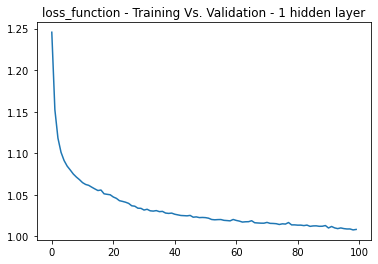

In [14]:
# Plot the loss over epochs

plt.plot(model_v0.history["loss"])
plt.title("loss_function - Training Vs. Validation - 1 hidden layer")
#plt.legend(["train", "test"])
plt.show()

In [13]:
model_moon_loss, model_moon_accuracy = nn_v0.evaluate(
    X_test, y_test, verbose=2
)
print(f"Loss: {model_moon_loss}, Accuracy: {model_moon_accuracy}")

19/19 - 0s - loss: 1.0410 - accuracy: 0.5103 - 196ms/epoch - 10ms/step
Loss: 1.0409588813781738, Accuracy: 0.5102739930152893


In [18]:
y_pred = nn_v0.predict(X_test)
y_pred

19/19 [==============================] - 0s 2ms/step


array([[5.1478008e-03, 1.9422759e-01, 4.3871608e-01, 3.6190856e-01],
       [1.7537571e-03, 5.6841802e-02, 4.8571438e-01, 4.5568997e-01],
       [7.6420605e-03, 2.0790899e-01, 5.1937050e-01, 2.6507843e-01],
       ...,
       [2.6117807e-02, 1.2065050e-01, 3.6983603e-01, 4.8339576e-01],
       [5.8559789e-03, 1.7752681e-02, 6.3134295e-01, 3.4504837e-01],
       [3.4587586e-04, 5.3627301e-02, 6.8051559e-01, 2.6551124e-01]],
      dtype=float32)